# Kernel smoothing

### Module import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import fklab.signals.smooth as smooth

### Kernels

Kernel functions are represented by objects. For one dimensional kernels, the main parameter is the bandwidth, which determines the width of the kernel. The kernels can be sampled at a user defined sampling interval for use in e.g. smoothing of signals (see below). Examples of 1-D kernels:

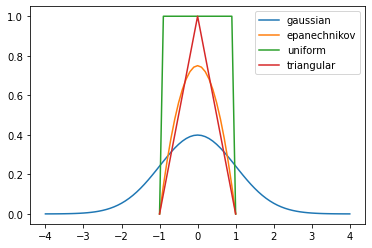

In [2]:
# 1-dimensional gaussian kernel with bandwidth (i.e. standard deviation) of 1
K1 = smooth.GaussianKernel(bandwidth=1)

# other 1-dimensional kernels
K2 = smooth.EpanechnikovKernel(bandwidth=1)
K3 = smooth.UniformKernel(bandwidth=1)
K4 = smooth.TriangularKernel(bandwidth=1)

# plot sampled kernels (sample interval of 0.1)
dx = 0.1
kernels = {"gaussian": K1, "epanechnikov": K2, "uniform": K3, "triangular": K4}

for s, K in kernels.items():
    k = K(dx=dx)  # sample the kernel with sample interval dx
    x = np.arange(-0.5 * (len(k) - 1), 0.5 * len(k)) * dx
    plt.plot(x, k, label=s)

plt.legend()

By specifying a vector of bandwidth, multi-dimensional (i.e. multivariate) kernels can be created. Here is an example of a 2-D gaussian kernel:

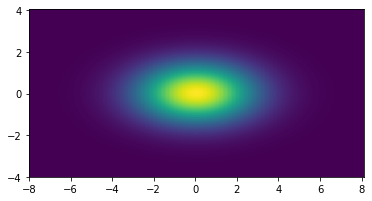

In [3]:
# 2-dimensional gaussian kernel
K = smooth.GaussianKernel(
    bandwidth=np.array([2.0, 1]), correlation=np.array([[1.0, 0], [0, 1]])
)

# sample kernel - notice that is possible to specify different dx for each dimension
dx = [0.2, 0.1]
k = K(dx=dx)

# plot kernel
x = np.array([-0.5 * (k.shape[0] - 1), 0.5 * k.shape[0]]) * dx[0]
y = np.array([-0.5 * (k.shape[1] - 1), 0.5 * k.shape[1]]) * dx[1]

plt.imshow(k.T, extent=np.concatenate((x, y)), origin="lower")

To construct multivariate kernel with correlation between dimensions, you can specify a correlation matrix. The matrix needs be square, have the same number of rows and columns as the dimensionality of the kernel and all elements need to be between -1 and 1.

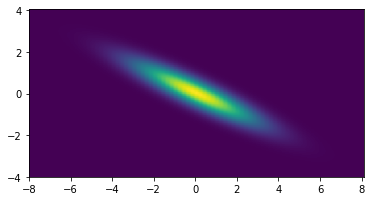

In [4]:
# 2-dimensional gaussian kernel with strong negative correlation
K = smooth.GaussianKernel(
    bandwidth=np.array([2.0, 1]), correlation=np.array([[1.0, -0.9], [-0.9, 1.0]])
)

# sample and plot kernel
dx = [0.2, 0.1]
k = K(dx=dx)

# plot kernel
x = np.array([-0.5 * (k.shape[0] - 1), 0.5 * k.shape[0]]) * dx[0]
y = np.array([-0.5 * (k.shape[1] - 1), 0.5 * k.shape[1]]) * dx[-1]

plt.imshow(k.T, extent=np.concatenate((x, y)), origin="lower")

Multivariate kernels come in two flavours: *symmetrical* and *multiplicative*. The default kernel type is *symmetrical* but this can be changed by the kerneltype property. Symmetrical kernels are rotationally symmetric and support correlations, whereas multiplicative kernels are constructed by multiplying several 1-D kernels and do not support correlations. Only for the gaussian kernel is the symmetrical kernel identical to the multiplicative kernel (as long as correlations are zero). The difference between the two kernel types can be easily seen for the triangular and uniform kernels.

Text(0.5, 1.0, 'multiplicative')

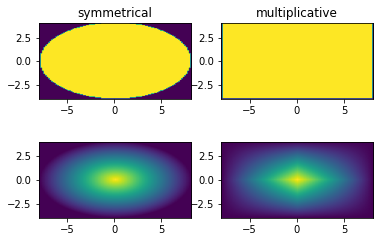

In [5]:
# first plot symmetrical and multiplicative uniform kernels
K = smooth.UniformKernel(bandwidth=np.array([1, 1]))
K.kerneltype = "symmetrical"

dx = 0.02
k = K(dx=dx)


hF, hA = plt.subplots(2, 2)
hA[0, 0].imshow(k.T, extent=np.concatenate((x, y)), origin="lower")

K.kerneltype = "multiplicative"
k = K(dx=dx)
hA[0, 1].imshow(k.T, extent=np.concatenate((x, y)), origin="lower")


# now create and plot symmetrical and multiplicative triangular kernels
K = smooth.TriangularKernel(bandwidth=np.array([1, 1]))
K.kerneltype = "symmetrical"

k = K(dx=dx)
hA[1, 0].imshow(k.T, extent=np.concatenate((x, y)), origin="lower")

K.kerneltype = "multiplicative"

k = K(dx=dx)
hA[1, 1].imshow(k.T, extent=np.concatenate((x, y)), origin="lower")

hA[0, 0].set_title("symmetrical")
hA[0, 1].set_title("multiplicative")

Different kinds of kernels can be combined into a *mixed kernel*. The combination will always be performed in a multiplicative way (of course the kernels themselves can still be symmetrical). Here is a 2-D mixed kernel that combines a gaussian and uniform kernel:

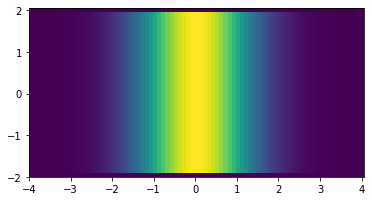

In [6]:
K1 = smooth.GaussianKernel(bandwidth=1)
K2 = smooth.UniformKernel(bandwidth=2)
K = smooth.MixedKernel(K1, K2)

dx = 0.1
k = K(dx=dx)

x = np.array([-0.5 * (k.shape[0] - 1), 0.5 * k.shape[0]]) * dx
y = np.array([-0.5 * (k.shape[1] - 1), 0.5 * k.shape[1]]) * dx

plt.imshow(k.T, extent=np.concatenate((x, y)), origin="lower")

### Smoothing data

Once a kernel has been created, it can be used to smooth data in an array. Here is an example for a 1-D signal by using a custom kernel and the Smoother class:

Text(0.5, 0, 'time (s)')

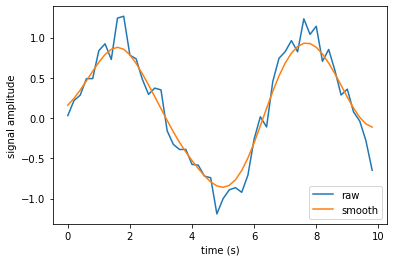

In [7]:
x = np.arange(start=0, stop=10, step=0.2)  # i.e. 10 seconds, 5 Hz sampling rate
y = np.sin(x) + np.random.uniform(
    low=-0.3, high=0.3, size=x.shape
)  # fake signal with noise
plt.plot(x, y, label="raw")

K = smooth.GaussianKernel(bandwidth=0.5)
S = smooth.Smoother(K)
ysmooth = S(y, delta=0.2)

plt.plot(x, ysmooth, label="smooth")
plt.legend(loc=4)
plt.ylabel("signal amplitude")
plt.xlabel("time (s)")

For classic kernels (gaussian, epanechnikov, uniform or triangular), a wrapper method called `create_smoother` is available for dimension 1 or 2. 

Text(0.5, 0, 'time (s)')

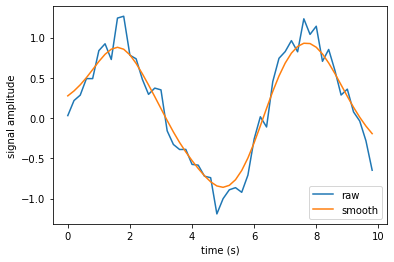

In [8]:
plt.plot(x, y, label="raw")

# the first argument is the dimension of the data - here 1d
S = smooth.create_smoother(1, kernel="gaussian", bandwidth=0.5, delta=0.2)

ysmooth = S(y)
plt.plot(x, ysmooth, label="smooth")
plt.legend(loc=4)
plt.ylabel("signal amplitude")
plt.xlabel("time (s)")

Example of smoothing a 2-D array:

Text(0.5, 1.0, 'smooth')

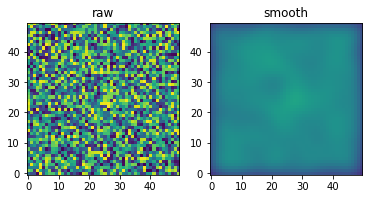

In [19]:
z = np.random.uniform(low=0, high=1, size=(50, 50))  # 50x50 pixels noise

S = smooth.create_smoother(
    2, kernel="gaussian", bandwidth=np.array([3, 3]), unbiased=False
)
zsmooth = S(z)

hF, hA = plt.subplots(1, 2)
hI = hA[0].imshow(z.T, origin="lower")
hI.set_clim(0, 1)
hI = hA[1].imshow(zsmooth.T, origin="lower")
hI.set_clim(0, 1)

hA[0].set_title("raw")
hA[1].set_title("smooth")

Notice that the smoothed data in the example above falls off towards the edges. The reason for this is that a value of zero is assumed everywhere outside the data range. To rather make no assumptions and treat the region outside the data range as missing, one can use the *unbiased* option, as shown below.

Text(0.5, 1.0, 'unbiased smooth')

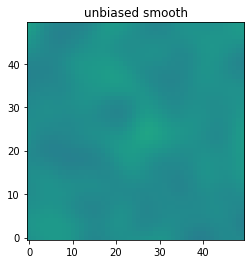

In [20]:
S = smooth.create_smoother(
    2, kernel="gaussian", bandwidth=np.array([3, 3]), unbiased=True
)
zsmooth = S(z)

hI = plt.imshow(zsmooth.T, origin="lower")
hI.set_clim(0, 1)
plt.gca().set_title("unbiased smooth")

There are two more smoothing options that are worth mentioning. The first is *nansaszero*, which sets any NaNs in the data or kernel to zero before smoothing. In combination with the *unbiased* option, NaNs will be treated as missing values. The second option is *normalize*, which controls if the kernel is normalized such that the integral (or more accurately the sum) is one. By default, normalize=True.

Finally, if you want to apply smoothing to some, but not all dimensions of an array, use the *NoKernel* dummy kernel. Here is an example:

Text(0.5, 1.0, 'smooth in x dimension only')

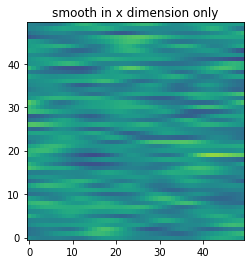

In [11]:
K1 = smooth.GaussianKernel(bandwidth=3)
K2 = smooth.NoKernel()

MK = smooth.MixedKernel(K1, K2)

S = smooth.Smoother(MK)
S.unbiased = True

zsmooth = S(z)

hI = plt.imshow(zsmooth.T, origin="lower")
hI.set_clim(0, 1)
plt.gca().set_title("smooth in x dimension only")